In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import spacy
import sklearn

In [2]:
pd.set_option('max_colwidth', 400)

In [3]:
df=pd.read_csv("/kaggle/input/symptom2disease/Symptom2Disease.csv")
le = sklearn.preprocessing.LabelEncoder()
df['label_num']=le.fit_transform(df['label'])

In [4]:
np.unique(df['label'])

array(['Acne', 'Arthritis', 'Bronchial Asthma', 'Cervical spondylosis',
       'Chicken pox', 'Common Cold', 'Dengue', 'Dimorphic Hemorrhoids',
       'Fungal infection', 'Hypertension', 'Impetigo', 'Jaundice',
       'Malaria', 'Migraine', 'Pneumonia', 'Psoriasis', 'Typhoid',
       'Varicose Veins', 'allergy', 'diabetes', 'drug reaction',
       'gastroesophageal reflux disease', 'peptic ulcer disease',
       'urinary tract infection'], dtype=object)

In [5]:
from datasets import Dataset
ds=Dataset.from_pandas(df[['label_num','text']])
new_ds=ds.train_test_split(test_size=0.3,shuffle=True)
new_ds

DatasetDict({
    train: Dataset({
        features: ['label_num', 'text'],
        num_rows: 840
    })
    test: Dataset({
        features: ['label_num', 'text'],
        num_rows: 360
    })
})

In [6]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
import torch 
device='cuda' if torch.cuda.is_available() else 'cpu'
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-uncased')
model=AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=24).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [7]:
model_name="Symptom2disease"
tokenizer.save_pretrained(model_name)
('Symptom2disease/tokenizer_config.json',
 'Symptom2disease/special_tokens_map.json',
 'Symptom2disease/vocab.txt',
 'Symptom2disease/added_tokens.json',
 'Symptom2disease/tokenizer.json')
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)
encoded_ds=new_ds.map(tokenize,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
new_ds['train']

Dataset({
    features: ['label_num', 'text'],
    num_rows: 840
})

In [9]:
encoded_ds['train']

Dataset({
    features: ['label_num', 'text', 'input_ids', 'attention_mask'],
    num_rows: 840
})

In [27]:
new_dataset=encoded_ds.remove_columns(['text'])
new_dataset=new_dataset.rename_column('label_num',"labels")
new_dataset.set_format("torch")

In [28]:
new_dataset['train']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 840
})

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(new_dataset['train'], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(new_dataset['test'], batch_size=8)

In [14]:
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(label,preds):
    label=label.detach().cpu().numpy()
    preds=preds.detach().cpu().cpu()
    f1=f1_score(label,preds,average='weighted')
    acc=accuracy_score(label,preds)
    return acc,f1

In [21]:
from torch import optim
optimizer = optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-5,eps=1e-5)

In [36]:
def train_batch(batch,label_name=):
  batch={k: v.to(device) for k,v in batch.items()}
  model.train()
  optimizer.zero_grad()
  pred=model(**batch)
  loss=pred.loss
  predictions=pred.logits.argmax(-1)
  labels=batch[label_name]
  acc,f1=compute_metrics(labels,predictions)
  loss.backward()
  optimizer.step()
  return loss.item(),acc,f1
@torch.no_grad()
def valid_batch(batch,label_name='labels'):
  batch={k:v.to(device) for k,v in batch.items()}
  model.eval()
  optimizer.zero_grad()
  pred=model(**batch)
  loss=pred.loss
  predictions=pred.logits.argmax(-1)
  labels=batch[label_name]
  acc,f1=compute_metrics(labels,predictions)
  return loss.item(),acc,f1

In [17]:
! pip install torch_snippets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 9.7 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26323 sha256=237fded2d2e268efb2d1dadc3ea559cb7e58f9e111c393e1e690c29a

In [51]:
from torch_snippets import *
n_epoch=10
log=Report(n_epoch)
for epochs in range(n_epoch):
  N = len(train_dataloader)
  for i,data in enumerate(train_dataloader):
    loss,acc,f1=train_batch(data)
    log.record(epochs+(i+1)/N,trn_loss=loss,trn_acc=acc,f1_score=f1,end='\r')
  N = len(eval_dataloader)
  for i,batch in enumerate(eval_dataloader):
    loss,acc,f1=valid_batch(batch)
    log.record(epochs+(i+1)/N,val_loss=loss,val_acc=acc,val_f1_score=f1,end='\r')
  log.report_avgs(epochs+1)

EPOCH: 1.000  val_f1_score: 0.969  val_loss: 0.141  trn_loss: 0.206  f1_score: 0.943  trn_acc: 0.946  val_acc: 0.969  (9.27s - 83.47s remaining)
EPOCH: 2.000  val_f1_score: 0.976  val_loss: 0.115  trn_loss: 0.014  f1_score: 0.998  trn_acc: 0.999  val_acc: 0.978  (18.63s - 74.52s remaining)
EPOCH: 3.000  val_f1_score: 0.985  val_loss: 0.098  trn_loss: 0.004  f1_score: 1.000  trn_acc: 1.000  val_acc: 0.986  (28.07s - 65.50s remaining)
EPOCH: 4.000  val_f1_score: 0.985  val_loss: 0.101  trn_loss: 0.002  f1_score: 1.000  trn_acc: 1.000  val_acc: 0.986  (37.52s - 56.28s remaining)
EPOCH: 5.000  val_f1_score: 0.985  val_loss: 0.104  trn_loss: 0.002  f1_score: 1.000  trn_acc: 1.000  val_acc: 0.986  (46.96s - 46.96s remaining)
EPOCH: 6.000  val_f1_score: 0.985  val_loss: 0.106  trn_loss: 0.002  f1_score: 1.000  trn_acc: 1.000  val_acc: 0.986  (56.40s - 37.60s remaining)
EPOCH: 7.000  val_f1_score: 0.985  val_loss: 0.108  trn_loss: 0.001  f1_score: 1.000  trn_acc: 1.000  val_acc: 0.986  (65.64s

100%|██████████| 111/111 [00:00<00:00, 648.13it/s]


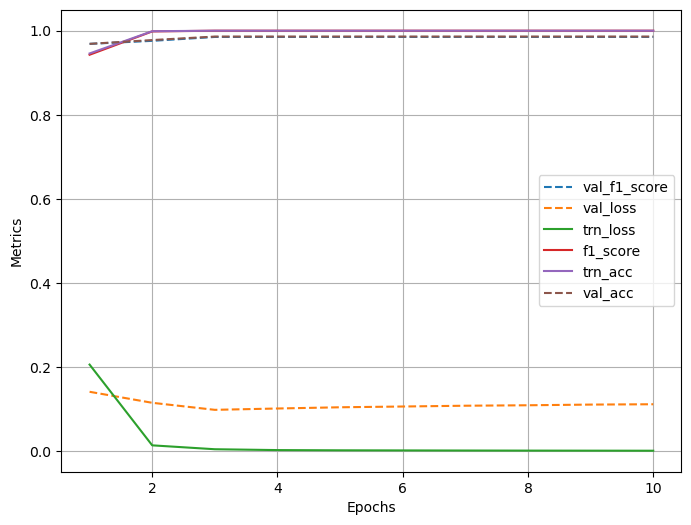

In [52]:
log.plot_epochs()